-----

# Lab3

# word tokenize
- 使用 nltk, pattern 或 textblob 做 word tokenize。
- 資料取原始檔案的前 50000 行

# 計算 skip bigram 

- $p_j^i$ 
- ngram 任何位置不包含符號
- skip bigram 不包含 stop words 與數字

In [1]:
from __future__ import division

k0 = 1
k1 = 1
U0 = 10
max_distance = 5

In [2]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords 
from collections import defaultdict, Counter
from math import sqrt
import numpy

In [3]:
def to_ngrams(words, length):
    return zip(*[words[i:] for i in range(length)])

def to_skipbigrams(words, distance):
    return zip(*[words, words[distance:]])

One way to validate ngram

In [4]:
eng_stopwords = set(stopwords.words('english'))
eng_symbols = set('{}"\'()[].,:;+!?-*/&|<>=~$')
def ngram_is_valid(ngram):
    first, last = ngram[0], ngram[-1]
    if first in eng_stopwords or last in eng_stopwords: return False
    if any( num in first or num in last for num in '0123456789'): return False
    if any( eng_symbol in word for word in ngram for eng_symbol in eng_symbols): return False
    return True

Anothor way of validating an ngram

In [5]:
import string
eng_stopwords = set(stopwords.words('english') + list(string.punctuation))
eng_symbols = list(string.punctuation)
eng_symbols.remove('-')
def ngram_is_valid(ngram):
    first, last = ngram[0], ngram[-1]
    if first in eng_stopwords or last in eng_stopwords:
        return False
    if any(num in first or num in last for num in '0123456789'):
        return False
    if any(eng_symbol in word for word in ngram for eng_symbol in eng_symbols):
        return False
    return True

### skip bigrams

In [6]:
%%time
skipbigrams = defaultdict(lambda: defaultdict(Counter))
with open('citeseerx_descriptions_sents.txt.50000') as text_file:
    for line in text_file:
        words = wordpunct_tokenize(line.strip())
        # words = wordpun_tokenize(line.strip())
        for n in range(1, max_distance+1):
            for ngram in filter(ngram_is_valid, to_ngrams(words, n + 1)):
                first, last = ngram[0], ngram[-1]
                skipbigrams[first][last][n] += 1
                skipbigrams[last][first][-n] += 1

CPU times: user 32.4 s, sys: 561 ms, total: 33 s
Wall time: 33.4 s


### 階段檢查資料

In [9]:
list(skipbigrams['play'].items())[:5]

[('user', Counter({-2: 1})),
 ('video', Counter({2: 1})),
 ('allow', Counter({-4: 1})),
 ('frames', Counter({-5: 1})),
 ('corresponding', Counter({5: 1}))]

In [10]:
list(skipbigrams['role'].items())[:5]

[('aspects', Counter({-2: 1})),
 ('important', Counter({-5: 1, -3: 2, -1: 39})),
 ('hierarchy', Counter({1: 2})),
 ('concept', Counter({-5: 1, -2: 1, 1: 1, 4: 1})),
 ('suggestion', Counter({-2: 1}))]

# 計算 skip bigram 的各種統計資訊 
$freq,\ \bar{f},\ \sigma,\ u_i,\ \bar{p_i}$

In [11]:
class Collocate:
    def __init__(self, collocation):
        self.collocation = dict(collocation)
        values = list(self.collocation.values())
        self.freq = sum(values)
        self.spread = numpy.var(values + [0] * (max_distance * 2 - len(values)))
        self.peak = self.freq / float(max_distance * 2) + k1 * sqrt(self.spread)
    def __getitem__(self, key):
        return self.collocation[key]
    def __repr__(self):
        return 'Collocates(freq={}, strength={}, spread={}, peak={}, {})'.format(self.freq, self.strength, self.spread, self.peak, self.collocation)
    def keys(self):
        return self.collocation.keys()
    def values(self):
        return self.collocation.values()
    def items(self):
        return self.collocation.items()
    def compute(self, avg_freq, dev):
        self.strength = (self.freq - avg_freq) / dev if dev else 0
    def prune_collocation(self):
        self.collocation = {index: freq for index, freq in self.items() if freq > self.peak}
        return len(self.collocation) > 0

In [12]:
class BaseWord:
    def __init__(self, base_word_str):
        self.collocates = {coll: Collocate(value) for coll, value in skipbigrams[base_word_str].items()}
        # compute_statistical_info
        freqs = [collocate.freq for collocate in self.collocates.values()]
        self.avg_freq = numpy.mean(freqs)
        self.dev = numpy.std(freqs)
        for collocate in self.collocates.values():
            collocate.compute(self.avg_freq, self.dev)
        self.filter_collocates()
    def __getitem__(self, key):
        return self.collocates[key]
    def __repr__(self):
        return 'BaseWord(avg_freq={}, dev={},\n{}\n}})'.format(self.avg_freq, self.dev, self.collocates)
    def values(self):
        return self.collocates.values()
    def items(self):
        return self.collocates.items()
    def filter_collocates(self):
        # Smadja's filtering skip-bigrams C1, C2
        self.collocates = {word: collocate for word, collocate in self.collocates.items() \
                           if collocate.strength > k0 and collocate.spread > U0}
        # Smadja's filtering skip-bigrams C3
        self.collocates = {word: collocate for word, collocate in self.collocates.items() \
                           if collocate.prune_collocation()}


In [13]:
class SkipgramDict(dict):
    def __init__(self):
        self.factory = BaseWord
    def __missing__(self, key):
        self[key] = self.factory(key)
        return self[key]

### 階段檢查資料
- $\bar{f}$ : `avg_freq`
- $\sigma$ : `dev`
- $u_i$ : `spread`
- $freq$ : `freq`


In [14]:
iskip_bigram_info = SkipgramDict()

In [15]:
iskip_bigram_info['play']

BaseWord(avg_freq=1.5247524752475248, dev=4.19710899889823,
{'role': Collocates(freq=70, strength=16.314860429578477, spread=221.0, peak=21.866068747318508, {3: 51}), 'important': Collocates(freq=23, strength=5.116676152654095, spread=22.409999999999997, peak=7.033920151417849, {2: 16})}
})

In [16]:
iskip_bigram_info['role']

BaseWord(avg_freq=1.6712517193947731, dev=3.4258562842764286,
{'important': Collocates(freq=42, strength=11.771873929943041, spread=134.95999999999998, peak=15.817228585166085, {-1: 39}), 'plays': Collocates(freq=27, strength=7.393406546811663, spread=34.010000000000005, peak=8.531809324729334, {-3: 20}), 'play': Collocates(freq=70, strength=19.945013045121613, spread=221.0, peak=21.866068747318508, {-3: 51}), 'central': Collocates(freq=13, strength=3.3068369892223775, spread=10.61, peak=4.557299494980466, {-1: 11}), 'The': Collocates(freq=19, strength=5.058223942474928, spread=19.490000000000002, peak=6.314748010928824, {-1: 15})}
})

In [17]:
list(skipbigrams['play']['role'].values())

[51, 5, 8, 2, 2, 1, 1]

## 使用 pandas 畫出 play role 的各距離數量

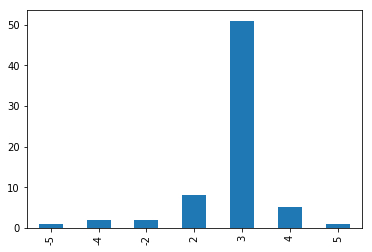

In [18]:
import pandas 
%matplotlib inline
play_role_distances_count = pandas.Series(list(skipbigrams['play']['role'].values()), index=list(skipbigrams['play']['role'].keys())).sort_index()
play_role_distances_count.plot(kind='bar')

# 依據 Smadja’s 三個規則篩選 skip bigrams

$$\begin{cases} 
strength = \frac{freq - \bar{f}}{\sigma} \ge k_0 & (C_1)\\
spread \ge u_0 & (C_2) \\
p_j^i \ge \bar{p_i} + (k_1 \times \sqrt{u_i}) & (C_3) 
\end{cases}$$

In [19]:
iskip_bigram_info['play']

BaseWord(avg_freq=1.5247524752475248, dev=4.19710899889823,
{'role': Collocates(freq=70, strength=16.314860429578477, spread=221.0, peak=21.866068747318508, {3: 51}), 'important': Collocates(freq=23, strength=5.116676152654095, spread=22.409999999999997, peak=7.033920151417849, {2: 16})}
})

In [20]:
%%time
for baseword in skipbigrams:
    iskip_bigram_info[baseword]

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


CPU times: user 53.8 s, sys: 745 ms, total: 54.5 s
Wall time: 55.2 s


## 使用 pandas Dataframe 整理與顯示資料

In [22]:
import pandas
collocations = [(baseword, word, i, collocate.strength, collocate.spread, collocate.peak, freq)
                for baseword, collocates in iskip_bigram_info.items()
                for word, collocate in collocates.items()
                for i, freq in collocate.items()]
collocations_df = pandas.DataFrame(collocations,
                                   columns = ['base word', 'collocate', 'distance', 'strength', 'spread', 'peak', 'p'])
collocations_df = collocations_df.set_index(['base word', 'collocate', 'distance']).sort_index()

### 列出 collocation Dataframe

In [23]:
collocations_df

strength    spread        peak    p
base word collocate    distance                                      
#         #            -2        38.086420    506.56   87.706888  107
                        2        38.086420    506.56   87.706888  107
          The          -3         2.043375     13.16    7.427671   10
                       -2         2.043375     13.16    7.427671    8
          We           -5         1.338951     20.04    7.076606    8
                       -4         1.338951     20.04    7.076606   14
          c             1         2.160779    114.20   14.686440   36
          ciency        1         2.747799    178.60   18.364131   45
          cient         1         8.852810   2043.44   60.604425  151
          ciently       1         2.160779    128.60   15.340194   38
          coe          -1         1.221547     43.04    8.960488   22
          cult          1         1.867269    103.45   13.671037   34
          di           -1        20.769322   9893.61  135.166628  334
          e            -1        24.115337  11877.84  150.385504  368
          ect           1         2.043375    115.36   14.540577   36
          ective        1         3.158714    270.21   22.138066   55
          ectively      1         1.162845     47.61    9.200000   23
          ects          1         1.984673    109.21   14.150359   35
          er            1         1.867269     96.85   13.341240   33
          erent         1        12.492336   3617.24   81.743495  202
          erential      1         1.456355     59.96   10.543384   26
          ers           1         1.456355     59.96   10.543384   26
          n            -1         2.512991     24.44    9.543683   16
                        1         2.512991     24.44    9.543683   12
          su           -1         2.865203    223.16   20.138541   50
          tra          -1         1.749865     85.61   12.552567   31
          two          -2         1.808567     15.84    7.379950   13
                        3         1.808567     15.84    7.379950    8
          usion         1         1.104143     43.56    8.800000   22
          x            -1         2.571693     52.41   11.939475   24
...                                    ...       ...         ...  ...
work      This         -1        18.888210    537.56   34.385340   79
          contribution -3         1.660808     10.76    4.480244   11
          done          1         4.072645     15.44    6.529377    8
                        3         4.072645     15.44    6.529377   11
          earlier      -1         2.349904     17.24    5.752108   14
          future       -1         4.244919     41.81    9.166065   22
          main         -4         2.005356     12.64    4.955278   12
          paper        -4         6.484481     28.20    9.310367   13
                       -3         6.484481     28.20    9.310367   15
          present      -2         4.417193     11.56    6.200000    7
                       -1         4.417193     11.56    6.200000   11
          previous     -1        13.547716    469.09   29.758486   73
          progress      2         2.005356     12.64    4.955278   12
          recent       -1         4.244919     60.41   10.472387   26
          well          1         1.833082     10.61    4.557299   11
works     previous     -1         9.569996     14.84    5.452272   13
world     data          1         5.351246     12.21    5.194281   12
          real         -1        22.833347    390.81   26.468915   66
          virtual      -1         3.952678     10.61    4.557299   11
worst     case          1        11.213565     43.21    8.873431   22
would     allow         1         6.998167     10.76    4.480244   11
          like          1        14.299831     31.81    7.940035   19
x         #            -1        10.766888     52.41   11.939475   12
                        1        10.766888     52.41   11.939475   24
years     In           -2         8.225192  

### 依據 strength 排序 collocation

In [24]:
collocations_df.sort_values(by='strength', ascending=False)[:10]

strength     spread        peak     p
base word collocate distance                                        
This      paper      1        48.524433  342586.69  782.409055  1953
also      We        -1        43.127860   13829.36  159.398299   394
In        paper      2        39.951056  288595.41  720.910769  1795
#         #          2        38.086420     506.56   87.706888   107
                    -2        38.086420     506.56   87.706888   107
present   We        -1        37.228588   43512.69  284.696956   700
order     In        -1        36.925210    3010.44   73.267477   183
show      We        -1        36.293592   13484.29  167.221876   388
paper     This      -1        35.929941  342586.69  782.409055  1953
The       paper      1        35.083989    7977.44  138.716516   295

### collocation Dataframe 的各欄位統計數據

In [25]:
collocations_df.describe()

,strength,spread,peak,p
count,5568.000000,5568.000000,5568.000000,5568.000000
mean,7.705839,386.690801,11.896456,24.915230
std,5.057564,8572.327215,24.475708,60.118164
min,1.010727,10.010000,4.400000,5.000000
25%,3.874649,14.050000,5.800000,12.000000
50%,6.719882,23.040000,7.576734,15.000000
75%,10.327578,51.840000,11.200000,23.000000
max,48.524433,342586.690000,782.409055,1953.000000


### role 的相關 collocations

In [26]:
collocations_df.loc['role']

,,strength,spread,peak,p
collocate,distance,,,,
The,-1,5.058224,19.49,6.314748,15
central,-1,3.306837,10.61,4.557299,11
important,-1,11.771874,134.96,15.817229,39
play,-3,19.945013,221.00,21.866069,51
plays,-3,7.393407,34.01,8.531809,20


### strength 的數據分佈

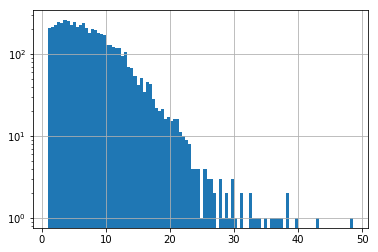

In [27]:
collocations_df.strength.hist(bins=100, log=True)